Using Theano backend.


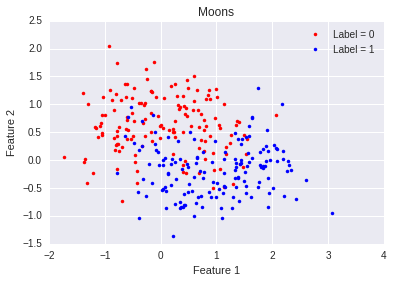

In [1]:
import warnings
warnings.filterwarnings('ignore')
from mlp import MLP
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
data, label = make_moons(n_samples=300, noise=0.4)

plt.plot(data[np.where(label==0)[0],0],data[np.where(label==0)[0],1],'r.', label='Label = 0')
plt.plot(data[np.where(label==1)[0],0],data[np.where(label==1)[0],1],'b.', label='Label = 1')

plt.title('Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()


# Using MLP with sklearn's cross_val_score

In [2]:
from sklearn.cross_validation import cross_val_score

clf = MLP(n_hidden=10, n_deep=3, l1_norm=0, drop=0.1, verbose=0)

scores = cross_val_score(clf, data, label, cv=5, n_jobs=1, scoring='roc_auc')
print(scores)

[ 0.94        0.92222222  0.89111111  0.93333333  0.85666667]


# Using MLP with sklearn's GridSearchCV

In [3]:
from sklearn.grid_search import GridSearchCV

params = {'n_hidden': [10, 15], 
         'l1_norm': [0.0],
         'n_deep': [2, 3],
         'drop': [0.1]}

clf_grid = GridSearchCV(clf, param_grid=params, scoring='roc_auc', cv=3, n_jobs=3)
scores = cross_val_score(clf_grid, data, label, cv=5, n_jobs=1, scoring='roc_auc')
print(scores)

[ 0.94        0.92222222  0.88666667  0.93222222  0.85777778]


# Extracting layer representation

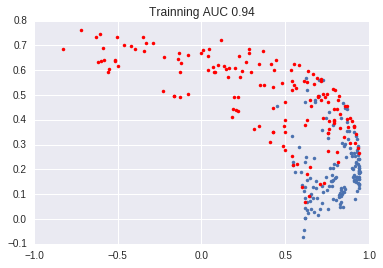

In [15]:
clf = MLP(n_hidden=8, n_deep=3, l2_norm=0.0, l1_norm=0.0, drop=0.0, verbose=0, early_stop=True,
          max_epoch=10000, patience=1000)
clf.fit(data, label)
layers = clf.feed_forward(data)
plt.plot(layers[2][label==0,0], layers[2][label==0,1],'.')
plt.plot(layers[2][label==1,0], layers[2][label==1,1],'r.')
plt.title('Trainning AUC {:.2f}'.format(clf.auc(data,label)))

# Plotting decision boundary

In [2]:
def plot_decision(clf, data):
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)

    x,y = np.meshgrid(np.linspace(xmin,xmax,100),np.linspace(ymin,ymax,100))
    mesh = np.vstack((x.ravel(), y.ravel())).T
    ypred = clf.predict(mesh)

    plt.contourf(x, y, ypred.reshape(x.shape), alpha=0.5)
    plt.scatter(data[label==0,0], data[label==0,1], marker='+')
    plt.scatter(data[label==1,0], data[label==1,1], c= 'red', marker='x')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

## L2 norm effects

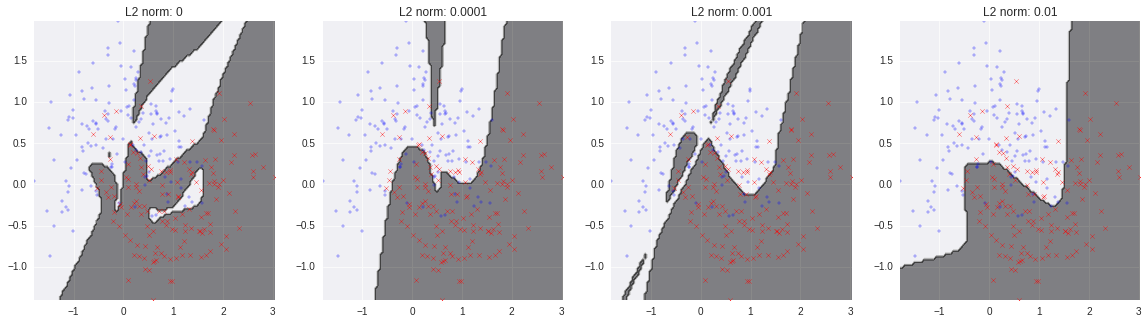

In [5]:
plt.figure(figsize=(25,5))
for n, l2 in enumerate([0, 0.0001, 0.001, 0.01]):
    clf = MLP(n_hidden=30, n_deep=3, l2_norm=l2, l1_norm=0, early_stop=False, max_epoch=10000)
    clf.fit(data, label)
    plt.subplot(1,5, n+1)
    plot_decision(clf, data)
    plt.title('L2 norm: {}'.format(l2))

## L1 norm effects

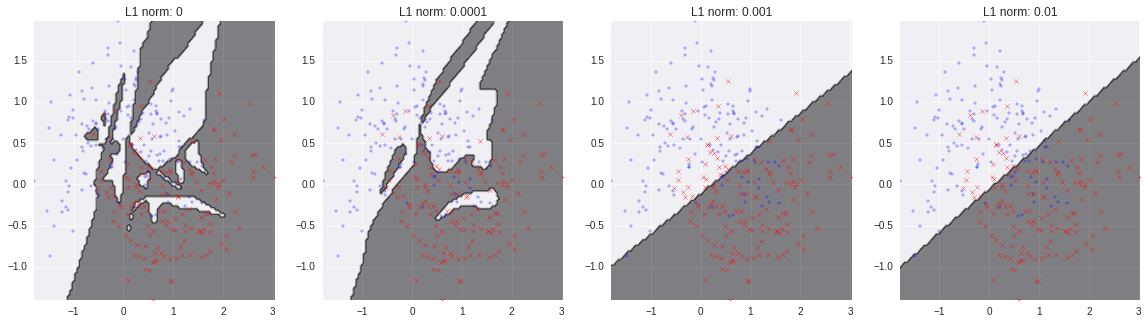

In [6]:
plt.figure(figsize=(25,5))
for n, l1 in enumerate([0, 0.0001, 0.001, 0.01]):
    clf = MLP(n_hidden=30, n_deep=3, l2_norm=0, l1_norm=l1, early_stop=False, max_epoch=10000)
    clf.fit(data, label)
    plt.subplot(1,5, n+1)
    plot_decision(clf, data)
    plt.title('L1 norm: {}'.format(l1))

## Dropout effects

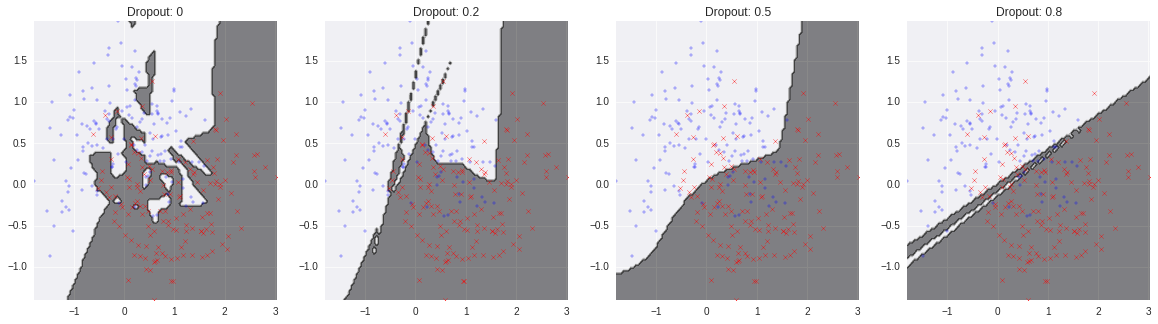

In [7]:
plt.figure(figsize=(20,5))
for n, drop in enumerate([0, 0.2, 0.5, 0.8]):
    clf = MLP(n_hidden=50, n_deep=3, drop=drop, early_stop=False, max_epoch=10000)
    clf.fit(data, label)
    plt.subplot(1,4, n+1)
    plot_decision(clf, data)
    plt.title('Dropout: {}'.format(drop))

# Simple loss history plotting

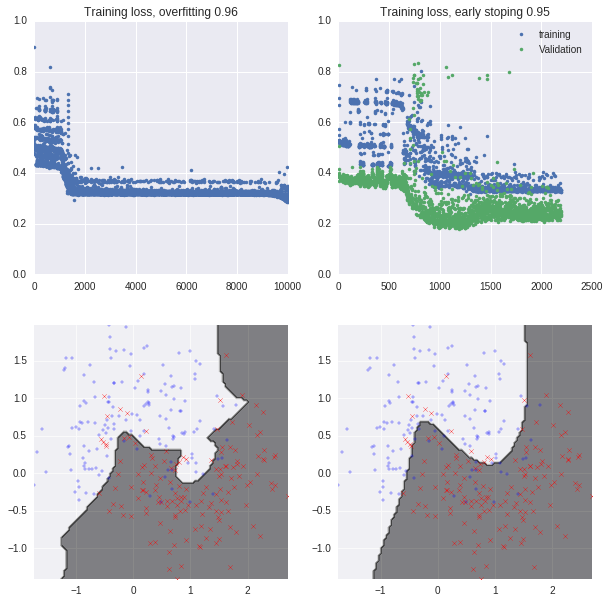

In [11]:
params = {'n_hidden': 50, 'n_deep': 3, 'l1_norm': 0, 'l2_norm': 0, 
          'drop': 0, 'verbose': 0, 'max_epoch':10000, 'patience':1000}

clf_ov = MLP(early_stop=False, **params)
clf_ov.fit(data, label)

clf_es = MLP(early_stop=True, **params)
clf_es.fit(data, label)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(clf_ov.history['loss'],'.')
plt.ylim(0,1)
plt.title('Training loss, overfitting {:.2f}'.format(clf_ov.auc(data, label)))
plt.subplot(2,2,3)
plot_decision(clf_ov, data)
plt.subplot(2,2,2)
plt.plot(clf_es.history['loss'],'.', label='training')
plt.plot(clf_es.history['val_loss'],'.', label='Validation')
plt.legend()
plt.ylim(0,1)
plt.title('Training loss, early stoping {:.2f}'.format(clf_es.auc(data, label)))
plt.subplot(2,2,4)
plot_decision(clf_es, data)

# Assessing optimization methods

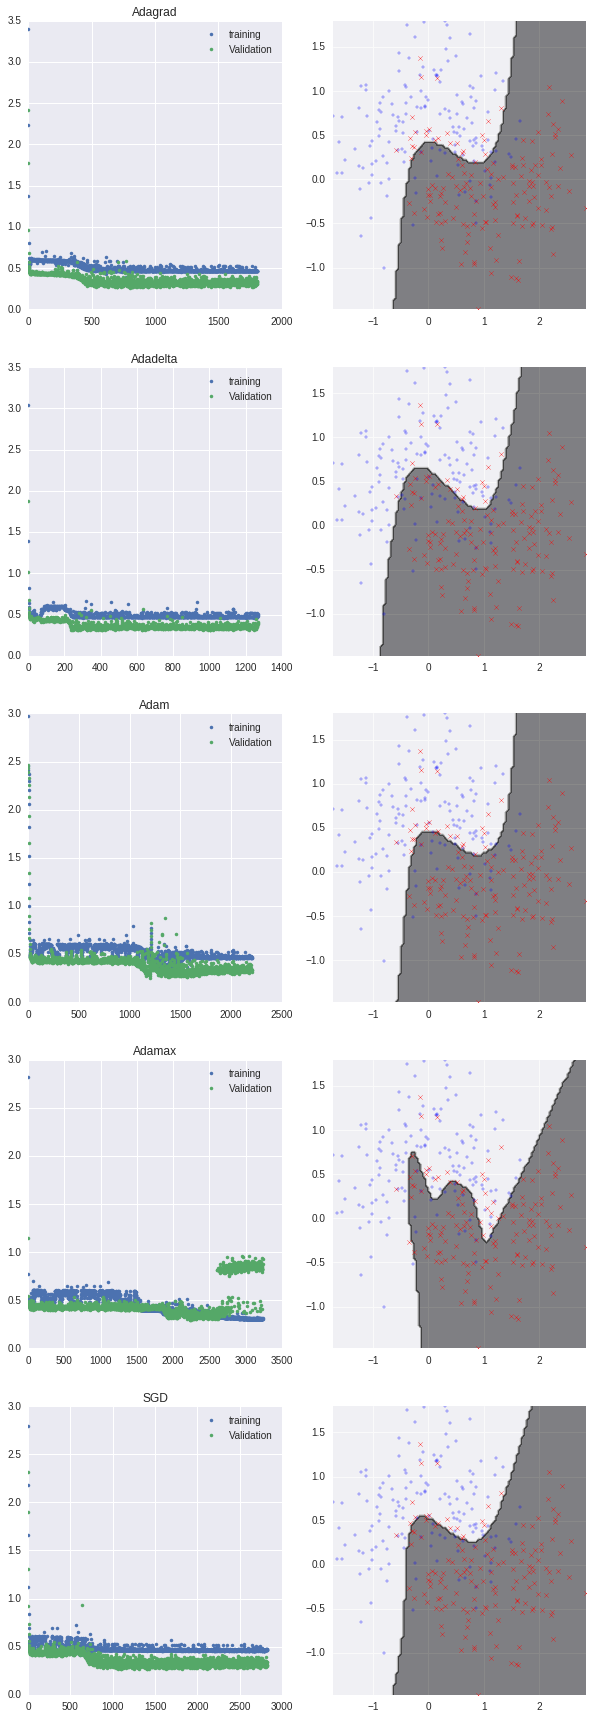

In [3]:
optimizers = ['Adagrad', 'Adadelta', 'Adam', 'Adamax', 'SGD']

plt.figure(figsize=(10,30))
for n, optim in enumerate(optimizers):
    params = {'n_hidden': 50, 'n_deep': 3, 
              'l1_norm': 0, 'l2_norm': 0, 
              'drop': 0, 'verbose': 0, 
              'max_epoch':10000, 'patience':1000,
              'early_stop': True, 'optimizer':optim}

    clf = MLP(**params)
    clf.fit(data, label)
    plt.subplot(5,2,2*n+1)
    plt.plot(clf.history['loss'],'.', label='training')
    plt.plot(clf.history['val_loss'],'.', label='Validation')
    plt.legend()
    plt.title(optim)
    plt.subplot(5,2,2*n+2)
    plot_decision(clf, data)
